# Multivariado
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna

2025-05-09 14:47:20.239956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 14:47:20.240532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 14:47:20.243177: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 14:47:20.250686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746823640.262775  216798 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746823640.26

In [2]:
df = pd.read_csv("Data/air_quality_clean.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406


### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


In [3]:
# variable a predecir CO(GT) Monoxido de cárbono
X = df.drop(columns=['CO(GT)']).values
y = df['CO(GT)'].values.reshape(-1, 1)

In [4]:
# escalar con minmax scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [77]:
# Código de sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size].flatten())
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12 #mejro resultado
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)

In [78]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [79]:
#MLP
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - val_loss: 0.0126
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - val_loss: 0.0101
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - val_loss: 0.0110
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0128
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0125
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0108
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0090
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [81]:
#predecir 
y_pred = model.predict(X_test)

# Invertir escala del min max
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


In [82]:
# resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.538
MSE: 0.704
R²: 0.617


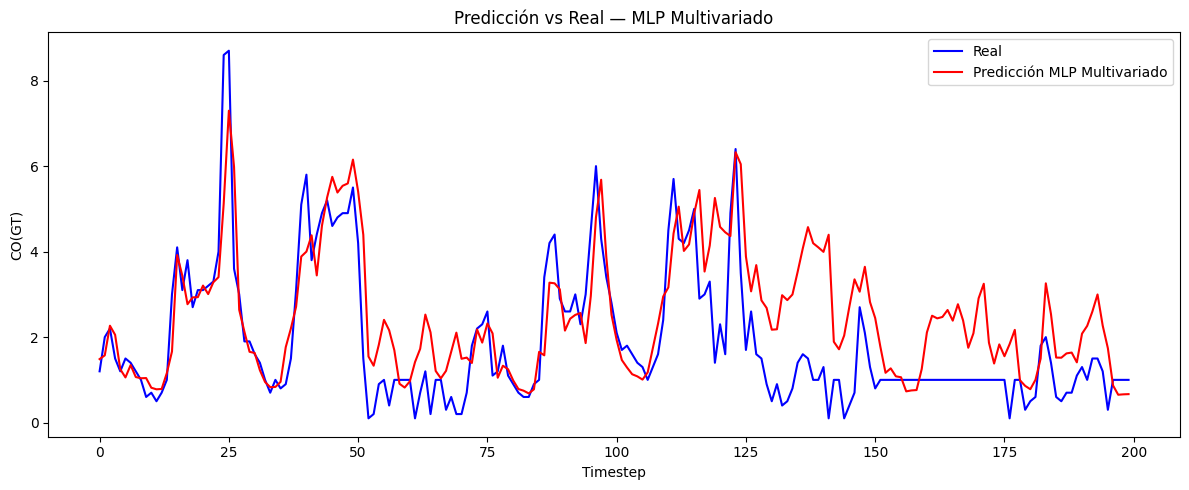

In [83]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP Multivariado', color='red')
plt.title('Predicción vs Real — MLP Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

El mejor resultado de este dio, con una ventana pequeña en el sliding window, y agregandole una capa para que fuera más profunda.

# CNN

In [93]:
#sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)

In [94]:
#CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Capa extra
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0155
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0134
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0115
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0104
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0100
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0117
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [96]:
#prediccion 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [97]:
#resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.610
MSE: 0.706
R²: 0.616


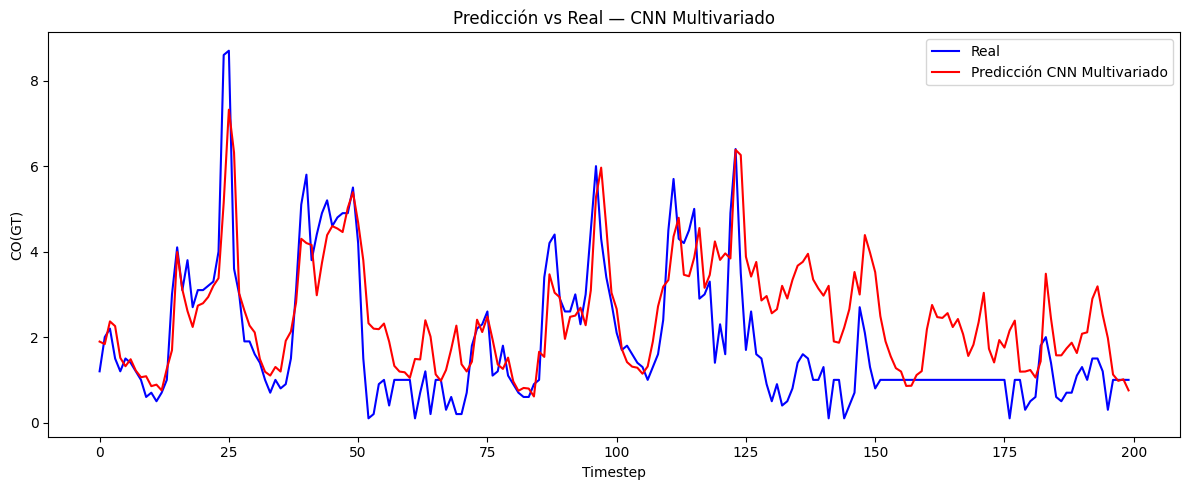

In [98]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Multivariado', color='red')
plt.title('Predicción vs Real — CNN Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo CNN multivariado obtuvo un desempeño bueno:

MAPE de 0.610, lo que indica un error relativo promedio del 61%.

MSE de 0.706, menor que el del modelo LSTM.

R² de 0.616, lo que significa que explica el 61.6% de la variabilidad en los datos reales de CO(GT).

Esto sugiere que la CNN es más precisa que el LSTM en capturar patrones multivariados de corto plazo, probablemente gracias a su capacidad para detectar patrones locales en el tiempo entre las variables.


# LSTM

In [111]:
def crear_ventanas_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_lstm(X_scaled, y_scaled, window_size)

In [112]:
#LSTM multivariado
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(window_size, X_seq.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0101 - val_loss: 0.0148
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_loss: 0.0124
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0118
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0109
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0111
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - val_loss: 0.0094
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [113]:
# Predecir
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [114]:
# Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


MAPE: 0.661
MSE: 0.778
R²: 0.577


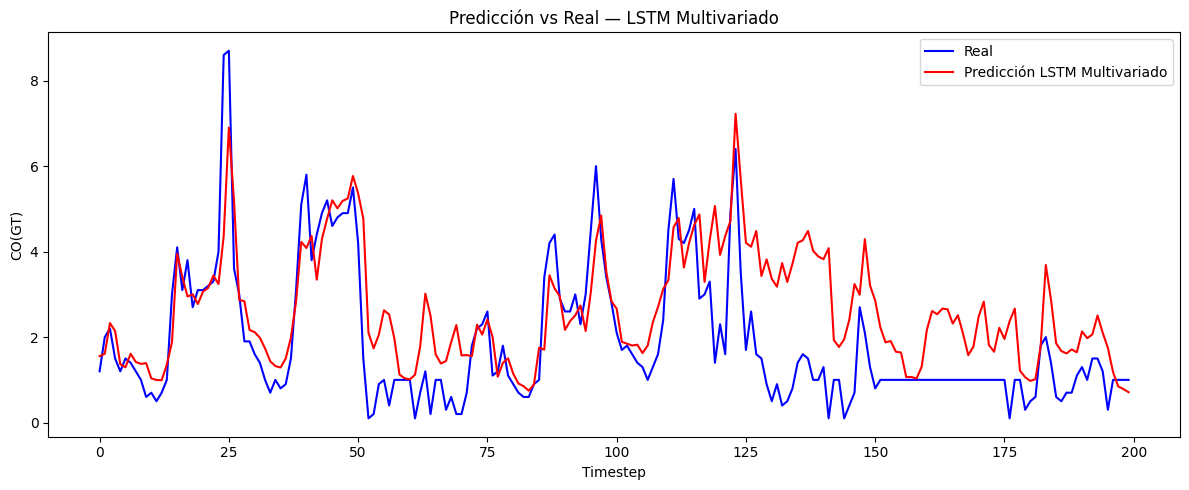

In [110]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM Multivariado', color='red')
plt.title('Predicción vs Real — LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo LSTM tiene un resultado aceptable. Predice de manera correcta el 57% de lla variablidad de los datos. No es el mejor de mis modelos. Tiene bastante error proporcional (MAPE = 0.684), lo que sugiere, Fluctuaciones o picos difíciles de aprender

# CONV-LSTM

In [ ]:
def crear_ventanas_conv_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_conv_lstm(X_scaled, y_scaled, window_size)

In [119]:
# Conv-LSTM 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Entrenar 
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0119
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0102
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0092
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0093
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

In [120]:
# Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [121]:
#Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.715
MSE: 0.865
R²: 0.530


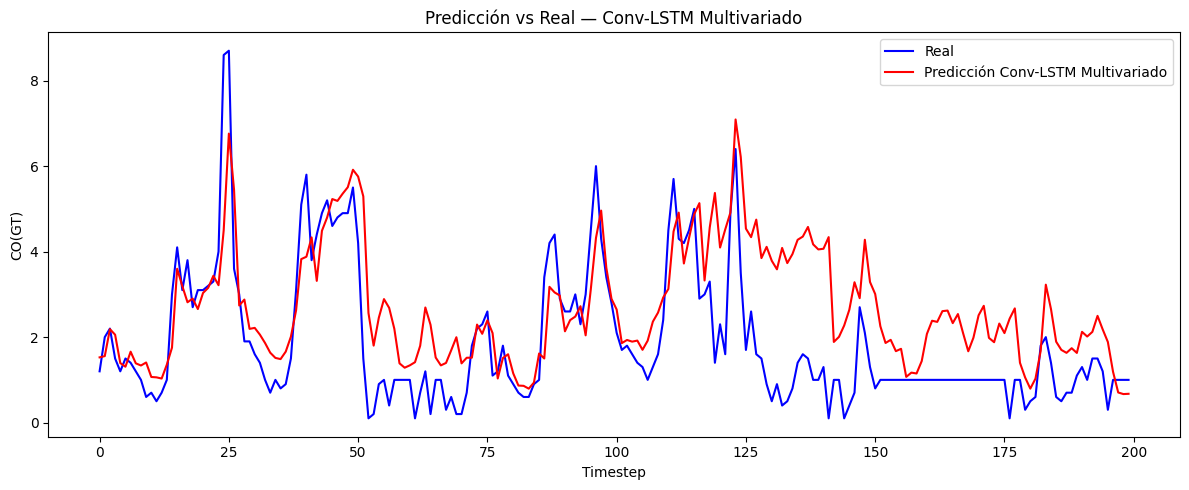

In [122]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM Multivariado', color='red')
plt.title('Predicción vs Real — Conv-LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Aunque el modelo Conv-LSTM combina la estructura de CNN y LSTM, en este caso no logró superar a los modelos individuales.
Este modelo aprende 53 % la variabilidad de los datos. 

# OPTUNA

In [124]:
def objective(trial):
    filters = trial.suggest_categorical('filters', [32, 64, 128])
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Modelo CNN
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamiento
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=50,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=0)

    # Predicción
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    return r2_score(y_test_inv, y_pred_inv)


In [125]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor R² obtenido: {study.best_value:.3f}")

[I 2025-05-09 20:24:13,647] A new study created in memory with name: no-name-1e5d58af-82b3-46f0-ac2a-892f06b88dd8
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:19,061] Trial 0 finished with value: 0.5148264954852089 and parameters: {'filters': 128, 'kernel_size': 4, 'dense_units': 79, 'activation': 'relu', 'lr': 0.00021812499369403842, 'batch_size': 64}. Best is trial 0 with value: 0.5148264954852089.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:22,872] Trial 1 finished with value: 0.5769974698275292 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 119, 'activation': 'relu', 'lr': 0.003101913300517778, 'batch_size': 64}. Best is trial 1 with value: 0.5769974698275292.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:24:26,213] Trial 2 finished with value: 0.5742202937897021 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 79, 'activation': 'tanh', 'lr': 0.0014605300944625045, 'batch_size': 64}. Best is trial 1 with value: 0.5769974698275292.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:24:31,938] Trial 3 finished with value: 0.5716538499449105 and parameters: {'filters': 128, 'kernel_size': 2, 'dense_units': 82, 'activation': 'tanh', 'lr': 0.008768831380135038, 'batch_size': 64}. Best is trial 1 with value: 0.5769974698275292.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:24:34,813] Trial 4 finished with value: 0.5954915219515042 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 51, 'activation': 'tanh', 'lr': 0.0005775037421382494, 'batch_size': 64}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:24:37,384] Trial 5 finished with value: 0.5509783575369218 and parameters: {'filters': 64, 'kernel_size': 5, 'dense_units': 113, 'activation': 'tanh', 'lr': 0.00018229919726837912, 'batch_size': 64}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:24:41,472] Trial 6 finished with value: 0.402104299084713 and parameters: {'filters': 128, 'kernel_size': 2, 'dense_units': 106, 'activation': 'tanh', 'lr': 0.0003435734423098627, 'batch_size': 16}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:45,674] Trial 7 finished with value: 0.5444617212432903 and parameters: {'filters': 64, 'kernel_size': 5, 'dense_units': 109, 'activation': 'tanh', 'lr': 0.0010493593462493032, 'batch_size': 16}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:49,242] Trial 8 finished with value: 0.5684435669012271 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 98, 'activation': 'relu', 'lr': 0.008057095577996505, 'batch_size': 32}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:54,057] Trial 9 finished with value: 0.5306249650365733 and parameters: {'filters': 32, 'kernel_size': 2, 'dense_units': 39, 'activation': 'relu', 'lr': 0.007732630192240357, 'batch_size': 32}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:24:59,453] Trial 10 finished with value: 0.5495525252972006 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 38, 'activation': 'tanh', 'lr': 0.0005793205916400398, 'batch_size': 16}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:02,540] Trial 11 finished with value: 0.5536300553873079 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 57, 'activation': 'relu', 'lr': 0.0022609035917365485, 'batch_size': 64}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:25:05,332] Trial 12 finished with value: 0.4859238901826426 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 126, 'activation': 'relu', 'lr': 0.002898418091948858, 'batch_size': 64}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:09,446] Trial 13 finished with value: 0.5755511192927718 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 58, 'activation': 'relu', 'lr': 0.0006797063607768385, 'batch_size': 64}. Best is trial 4 with value: 0.5954915219515042.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:14,396] Trial 14 finished with value: 0.6063814711926343 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 55, 'activation': 'tanh', 'lr': 0.00010327637804897219, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:18,610] Trial 15 finished with value: 0.5184323512626128 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 54, 'activation': 'tanh', 'lr': 0.00010010445215542695, 'batch_size': 32}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:22,514] Trial 16 finished with value: 0.5886354451491895 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 67, 'activation': 'tanh', 'lr': 0.00010523371975197033, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:25:25,128] Trial 17 finished with value: 0.5397031578260405 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 47, 'activation': 'tanh', 'lr': 0.0003650414954032202, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:29,669] Trial 18 finished with value: 0.5676221794247973 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 69, 'activation': 'tanh', 'lr': 0.00019466254176675812, 'batch_size': 32}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:37,247] Trial 19 finished with value: 0.5677749471275246 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 35, 'activation': 'tanh', 'lr': 0.0003937792866389907, 'batch_size': 16}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:41,915] Trial 20 finished with value: 0.5160225336052873 and parameters: {'filters': 32, 'kernel_size': 4, 'dense_units': 47, 'activation': 'tanh', 'lr': 0.00462074478292304, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:46,695] Trial 21 finished with value: 0.4522678858744662 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 68, 'activation': 'tanh', 'lr': 0.00010151771191015708, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:48,807] Trial 22 finished with value: 0.4935897441424518 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 66, 'activation': 'tanh', 'lr': 0.0001452192606602256, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:52,605] Trial 23 finished with value: 0.5603057005700192 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 87, 'activation': 'tanh', 'lr': 0.00015015824876669386, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:25:56,294] Trial 24 finished with value: 0.5779602157596393 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 51, 'activation': 'tanh', 'lr': 0.0002709967247862492, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2025-05-09 20:26:00,674] Trial 25 finished with value: 0.40404749815470054 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 63, 'activation': 'tanh', 'lr': 0.0008046353867228894, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-09 20:26:04,788] Trial 26 finished with value: 0.5717679976107215 and parameters: {'filters': 64, 'kernel_size': 3, 'dense_units': 73, 'activation': 'tanh', 'lr': 0.0005426524651622277, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-09 20:26:07,489] Trial 27 finished with value: 0.5702662581167011 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 43, 'activation': 'tanh', 'lr': 0.0001244048224007614, 'batch_size': 64}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:26:12,664] Trial 28 finished with value: 0.5826495001052736 and parameters: {'filters': 32, 'kernel_size': 2, 'dense_units': 59, 'activation': 'tanh', 'lr': 0.0002622843198839835, 'batch_size': 32}. Best is trial 14 with value: 0.6063814711926343.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-09 20:26:18,076] Trial 29 finished with value: 0.5014157682615303 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 32, 'activation': 'tanh', 'lr': 0.0013556604845241817, 'batch_size': 16}. Best is trial 14 with value: 0.6063814711926343.


Mejores hiperparámetros encontrados:
{'filters': 64, 'kernel_size': 3, 'dense_units': 55, 'activation': 'tanh', 'lr': 0.00010327637804897219, 'batch_size': 64}
Mejor R² obtenido: 0.606


In [ ]:
# Extraer mejores hiperparámetros
params = study.best_params

filters = params['filters']
kernel_size = params['kernel_size']
dense_units = params['dense_units']
activation = params['activation']
learning_rate = params['lr']
batch_size = params['batch_size']

In [127]:
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(dense_units, activation=activation))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Entrenamiento final con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0186 - val_loss: 0.0133
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0111
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0144
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0142
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0132
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0122
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0121
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0121


In [ ]:
# Predicción
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

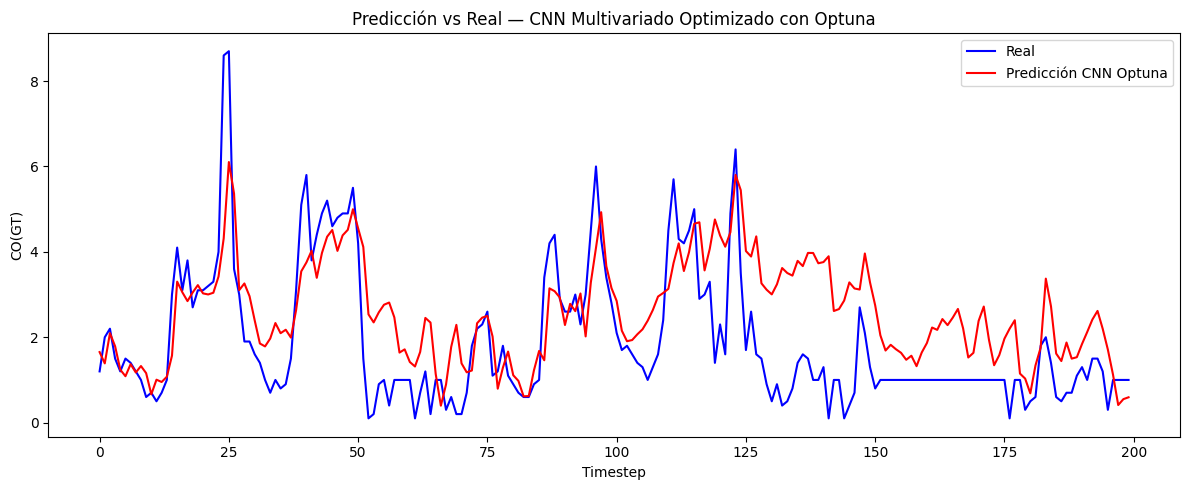

In [128]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Optuna', color='red')
plt.title('Predicción vs Real — CNN Multivariado Optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo prácticamente el mismo resultado en la r2. Aún asi se ajusta de manera aceptable a los datois la predicción.

Los resultados no fueron tan bienos como los modelos que solo usaban una variable. Lo que podriamos hacer es usar menos variables para hacer el modelo. Esto lo intentaremos con el mejor modelo a parte del optuna.

In [131]:
# Calcular correlación
correlaciones = df.corr(numeric_only=True)['CO(GT)'].drop('CO(GT)').sort_values(key=abs, ascending=False)

# Mostrar
print(correlaciones)


PT08.S2(NMHC)    0.767366
C6H6(GT)         0.762027
PT08.S1(CO)      0.751593
PT08.S5(O3)      0.742271
PT08.S3(NOx)    -0.608512
PT08.S4(NO2)     0.508368
RH               0.037791
AH              -0.029071
T               -0.017483
Name: CO(GT), dtype: float64


Basado en los resultados de tu análisis de correlación con CO(GT), podemos seleccionar las 5 variables más relevantes:
1. PT08.S2(NMHC)

2. C6H6(GT)

3. PT08.S1(CO)

4. PT08.S5(O3)

5. PT08.S3(NOx)

In [132]:
# Seleccionar solo las variables más relevantes
variables_seleccionadas = ['PT08.S2(NMHC)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)', 'PT08.S3(NOx)']
X = df[variables_seleccionadas].values
y = df['CO(GT)'].values.reshape(-1, 1)


Ahora usaré el mejor modelo que fue la cnn con estas variables

In [133]:
#Escalar
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [134]:
#Crear ventanas para CNN 
def crear_ventanas_cnn(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_cnn(X_scaled, y_scaled, window_size)


In [ ]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [141]:
# Modelo CNN multivariado reducido 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Capa extra
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Entrenar ---
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0163
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - val_loss: 0.0152
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0138
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0125
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0129
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0137
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - val_loss: 0.0130


In [142]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [143]:
#resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.566
MSE: 0.740
R²: 0.598


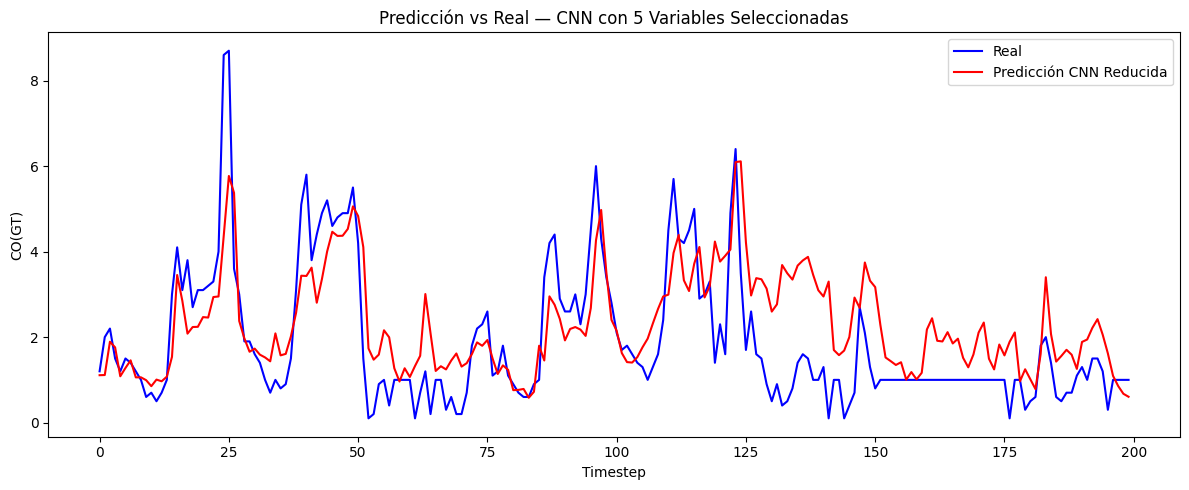

In [144]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Reducida', color='red')
plt.title('Predicción vs Real — CNN con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


MAPE fue mejor con solo 5 variables → El modelo fue más preciso proporcionalmente.

Pero R² fue ligeramente menor, indicando que explicó un poco menos de la variabilidad total.

Esto sugiere que las 5 variables principales contienen la mayor parte de la información útil, pero las otras variables todavía aportan algo (aunque poco).



# MLP con 5 variables

In [154]:

# Crear ventanas (MLP requiere 2D, ventana aplanada)
def crear_ventanas_mlp(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        ventana = X[i:i+window_size].flatten()
        Xs.append(ventana)
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_mlp(X_scaled, y_scaled, window_size)

In [155]:
# Modelo MLP 
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081 - val_loss: 0.0163
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0185
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0158
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0135
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0114
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0115
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0118
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0107


In [156]:
#Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [157]:
# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.587
MSE: 0.756
R²: 0.590


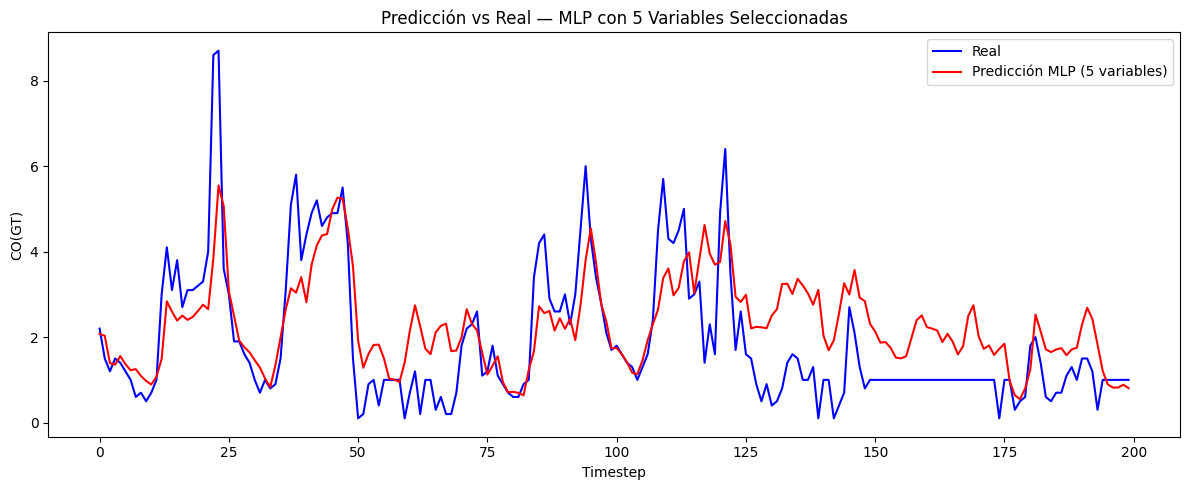

In [158]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP (5 variables)', color='red')
plt.title('Predicción vs Real — MLP con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo mejor resultado con todas las variables, muy poquita diferencia 2%. Pero aún así es mayor

Eliminar variables no siempre mejora R², aunque puede reducir MAPE (error relativo).

Las variables eliminadas quizás no están fuertemente correlacionadas individualmente, pero sí aportan al modelo de forma conjunta.

Para redes neuronales, a veces más variables (aunque ruidosas) permiten aprender mejor la estructura de los datos.